In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import torch
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split

mean = (0.5071, 0.4865, 0.4409)
std  = (0.2673, 0.2564, 0.2762)

BATCH_SIZE = 64

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = CIFAR100(root='data', train=True, transform=transform_train, download=True)
test_data = CIFAR100(root='data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 169M/169M [00:16<00:00, 10.1MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


### Importing VGG-11 pre-trained model on CIFAR100.

## PQT

In [3]:
!pip install torchao

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00


In [34]:
from torchao.quantization import (
    quantize_,
    int4_weight_only,
    int8_weight_only,

    # Compute bound models
    int8_dynamic_activation_int8_semi_sparse_weight,
    int8_dynamic_activation_int8_weight,

    # Device capability 8.9+
    float8_weight_only,
    float8_dynamic_activation_float8_weight,
)

In [25]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
import torch

def evaluate_model(model, test_loader, device):
    loss_func = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return {
        'test_loss': avg_loss,
        'test_accuracy': accuracy
    }
def evaluate_model_16(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass with autocast for FP16
            with autocast():
                outputs = model(inputs.half())  # Ensure inputs are in half precision
                loss = nn.CrossEntropyLoss()(outputs, labels)

            total_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return {
        'test_loss': avg_loss,
        'test_accuracy': accuracy
    }
def evaluate_model_bf16(model, test_loader, device):
    loss_func = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs.bfloat16())
            loss = loss_func(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return {
        'test_loss': avg_loss,
        'test_accuracy': accuracy
    }

In [ ]:
import torch.nn as nn
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            # Convert to float to count non-zero elements for quantized tensors
            num_counted_elements += (param.dequantize() != 0).sum().item()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

# Base VGG-11 pretrained finetuned for CIFAR100 model accuracy.

In [26]:
base_stats = evaluate_model(model, test_loader, device)
print("Accuracy and loss of funetuned-pre-trained VGG-11 on CIFAR-100: ", base_stats)

Accuracy and loss of funetuned-pre-trained VGG-11 on CIFAR-100:  {'test_loss': 1.4987759712219237, 'test_accuracy': 0.7077}


# INT-4 PTQ.

In [ ]:
import torch
import copy
import torch.nn.functional as F

def int4_weight_only():
    return {"bits": 4, "scale_bits": 8}

def quantize_(tensor, config):
    num_bits = config["bits"]

    scale = tensor.abs().amax(dim=list(range(1, tensor.dim())), keepdim=True)
    scale = torch.maximum(scale, torch.tensor(1e-8))

    min_val = -(2**(num_bits-1))
    max_val = 2**(num_bits-1) - 1

    scaled_tensor = torch.clamp(torch.round(tensor / scale * max_val), min_val, max_val)

    quantized = scaled_tensor * scale / max_val

    return quantized

def pad_to_multiple_of_16(tensor):
    if len(tensor.shape) < 2:
        return tensor

    pad_size = (16 - tensor.size(0) % 16) % 16
    if pad_size > 0:
        if len(tensor.shape) == 2:
            return F.pad(tensor, (0, 0, 0, pad_size))
        elif len(tensor.shape) == 4:
            return F.pad(tensor, (0, 0, 0, 0, 0, pad_size))
    return tensor

def quantize_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    int4_weight_only_model = copy.deepcopy(model).to("cpu")

    print("Number of params before PQT: ", sum(p.numel() for p in model.parameters()))
    print("Model size before PQT: ", sum(p.numel() * 32 for p in model.parameters()) // 8)  # Size in bytes
    print("Accuracy and loss of model before PQT: ", base_stats)

    quantized_layers = 0
    skipped_layers = 0

    for name, module in int4_weight_only_model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            if hasattr(module, 'weight') and module.weight is not None:
                try:
                    original_weight = module.weight.data.clone()

                    padded_weight = pad_to_multiple_of_16(original_weight)

                    quantized_weight = quantize_(padded_weight, int4_weight_only())

                    if torch.isnan(quantized_weight).any() or torch.isinf(quantized_weight).any():
                        raise ValueError(f"Invalid values in quantized weights for {name}")

                    with torch.no_grad():
                        if padded_weight.shape == original_weight.shape:
                            module.weight.data.copy_(quantized_weight)
                        else:
                            module.weight.data.copy_(quantized_weight[:original_weight.shape[0]])

                    if not torch.allclose(module.weight.data[:original_weight.shape[0]],
                                        quantized_weight[:original_weight.shape[0]], rtol=1e-3):
                        raise ValueError(f"Weight update failed for {name}")

                    quantized_layers += 1
                    print(f"Successfully quantized {name}")

                except Exception as e:
                    print(f"Error quantizing {name}: {str(e)}")
                    module.weight.data.copy_(original_weight)
                    skipped_layers += 1

    print(f"\nQuantization summary:")
    print(f"Quantized layers: {quantized_layers}")
    print(f"Skipped layers: {skipped_layers}")

    print("\nPost-quantization statistics:")
    print("Number of params after PQT: ", sum(p.numel() for p in int4_weight_only_model.parameters()))
    print("Model size after PQT: ", sum(p.numel() * 4 for p in int4_weight_only_model.parameters()) // 8)  # Size in bytes

    return int4_weight_only_model.to(device)

try:
    int4_weight_only_model = quantize_model()
    int4_stats_PQT = evaluate_model(int4_weight_only_model, test_loader, device)
    print("Accuracy and loss of model after PQT: ", int4_stats_PQT)
except Exception as e:
    print(f"\nAn error occurred during quantization: {str(e)}")

Number of params before PQT:  9802596
Model size before PQT:  39210384
Accuracy and loss of model before PQT:  {'test_loss': 1.4987759712219237, 'test_accuracy': 0.7077}
Successfully quantized features.0
Successfully quantized features.4
Successfully quantized features.8
Successfully quantized features.11
Successfully quantized features.15
Successfully quantized features.18
Successfully quantized features.22
Successfully quantized features.25
Successfully quantized classifier.0
Successfully quantized classifier.3
Successfully quantized classifier.6

Quantization summary:
Quantized layers: 11
Skipped layers: 0

Post-quantization statistics:
Number of params after PQT:  9802596
Model size after PQT:  4901298
Accuracy and loss of model after PQT:  {'test_loss': 1.5639029554367065, 'test_accuracy': 0.6905}


# INT-4 QAT.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import copy
import torch.nn.functional as F

class FakeQuantize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=4):
        ctx.num_bits = num_bits
        ctx.save_for_backward(x)

        scale = x.abs().amax(dim=list(range(1, x.dim())), keepdim=True)
        scale = torch.maximum(scale, torch.tensor(1e-8, device=x.device))

        n = 2 ** (num_bits - 1)
        min_val = -n
        max_val = n - 1

        x_scaled = torch.round(x / scale * max_val)
        x_clipped = torch.clamp(x_scaled, min_val, max_val)
        x_quantized = x_clipped * scale / max_val

        return x_quantized

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        n = 2 ** (ctx.num_bits - 1)
        mask = (x >= -n) & (x <= n-1)
        return grad_output * mask.float(), None

class QuantizedLayer(nn.Module):
    def __init__(self, module, num_bits=4):
        super().__init__()
        self.module = module
        self.num_bits = num_bits
        self.fake_quantize = FakeQuantize.apply

    def forward(self, x):
        if hasattr(self.module, 'weight') and self.module.weight is not None:
            quantized_weight = self.fake_quantize(self.module.weight, self.num_bits)
            original_weight = self.module.weight.data.clone()
            self.module.weight.data = quantized_weight
            out = self.module(x)
            self.module.weight.data = original_weight
            return out
        return self.module(x)

def apply_qat_to_model(model, num_bits=4):
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            setattr(model, name, QuantizedLayer(module, num_bits))
        else:
            apply_qat_to_model(module, num_bits)
    return model

def train_with_qat():
    learning_rate = 1e-5
    num_epochs = 3

    qat_model = copy.deepcopy(int4_weight_only_model).to(device)

    qat_model = apply_qat_to_model(qat_model)

    qat_model.train()

    optimizer = optim.Adam(qat_model.parameters(), lr=learning_rate)

    loss_func = nn.CrossEntropyLoss()

    best_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = qat_model(inputs)
            loss = loss_func(outputs, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(qat_model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        qat_model.eval()
        test_stats = evaluate_model(qat_model, test_loader, device)
        qat_model.train()

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"Training Loss: {total_loss / len(train_loader):.4f}")
        print(f"Training Accuracy: {100 * correct / total:.2f}%")
        print(f"Test Loss: {test_stats['test_loss']:.4f}")
        print(f"Test Accuracy: {test_stats['test_accuracy']*100:.2f}%")

        if test_stats['test_accuracy'] > best_accuracy:
            best_accuracy = test_stats['test_accuracy']
            best_model = copy.deepcopy(qat_model)
            print(f"New best model saved with accuracy: {best_accuracy*100:.2f}%")

        print("-" * 60)

    return best_model

try:
    print("Starting Quantization-Aware Training...")
    best_qat_model = train_with_qat()

    best_qat_model.eval()
    final_stats = evaluate_model(best_qat_model, test_loader, device)
    print("\nFinal QAT Model Statistics:")
    print(f"Test Accuracy: {final_stats['test_accuracy']*100:.2f}%")
    print(f"Test Loss: {final_stats['test_loss']:.4f}")

except Exception as e:
    print(f"An error occurred during QAT: {str(e)}")

Starting Quantization-Aware Training...

Epoch 1/3
Training Loss: 0.1432
Training Accuracy: 96.51%
Test Loss: 1.7414
Test Accuracy: 66.94%
New best model saved with accuracy: 66.94%
------------------------------------------------------------

Epoch 2/3
Training Loss: 0.1078
Training Accuracy: 97.31%
Test Loss: 1.7241
Test Accuracy: 68.25%
New best model saved with accuracy: 68.25%
------------------------------------------------------------

Epoch 3/3
Training Loss: 0.0619
Training Accuracy: 98.47%
Test Loss: 1.7109
Test Accuracy: 69.27%
New best model saved with accuracy: 69.27%
------------------------------------------------------------

Final QAT Model Statistics:
Test Accuracy: 69.27%
Test Loss: 1.7109


# INT-8 PTQ.

In [36]:
int8_weight_only_model = copy.deepcopy(model)
int8_weight_only_model = int8_weight_only_model.to(device)

print("Number of params before PQT: ", get_num_parameters(model))
print("Model size before PQT: ", get_model_size(model))
print("Accuracy and loss of model before PQT: ", base_stats)

quantize_(int8_weight_only_model, int8_weight_only())
int8_stats_PQT = evaluate_model(int8_weight_only_model, test_loader, device)

print("Number of params after PQT: ", get_num_parameters(int8_weight_only_model, count_nonzero_only=True))
print("Model size After PQT: ", get_model_size(int8_weight_only_model, data_width=8, count_nonzero_only=True))
print("Accuracy and loss of model after PQT: ", int8_stats_PQT)


Number of params before PQT:  9802596
Model size before PQT:  313683072
Accuracy and loss of model before PQT:  {'test_loss': 1.4987759712219237, 'test_accuracy': 0.7077}
Number of params after PQT:  9733648
Model size After PQT:  77869184
Accuracy and loss of model after PQT:  {'test_loss': 1.4986346250534057, 'test_accuracy': 0.7078}


# INT-8 QAT.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import copy

learning_rate = 1e-4

int8_weight_only_model = copy.deepcopy(int8_weight_only_model)
int8_weight_only_model.train()  # Set the model to training mode

torch.quantization.prepare_qat(int8_weight_only_model, inplace=True)

params_to_optimize = [param for param in int8_weight_only_model.parameters() if param.is_leaf and param.requires_grad]
optimizer = optim.SGD(params_to_optimize, lr=learning_rate)

loss_func = nn.CrossEntropyLoss()

def apply_qat_to_model(model):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
            module.qat = True

apply_qat_to_model(int8_weight_only_model)

for epoch in range(20):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = int8_weight_only_model(inputs)
        loss = loss_func(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    stats = evaluate_model(int8_weight_only_model, test_loader, device)

    print(f"Epoch {epoch + 1}/{20}")
    print(f"Training Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {100 * correct / total:.2f}%")
    print(f"Test Loss: {stats['test_loss']}, Test Accuracy: {stats['test_accuracy']}")

int8_stats_PQT = evaluate_model(int8_weight_only_model, test_loader, device)
print("Accuracy and loss of model after training: ", int8_stats_PQT)

Epoch 1/20
Training Loss: 0.0518, Training Accuracy: 98.77%
Test Loss: 1.637298387145996, Test Accuracy: 0.6945
Epoch 2/20
Training Loss: 0.0043, Training Accuracy: 99.91%
Test Loss: 1.6239397455215454, Test Accuracy: 0.6983
Epoch 3/20
Training Loss: 0.0025, Training Accuracy: 99.95%
Test Loss: 1.62205604763031, Test Accuracy: 0.6999
Epoch 4/20
Training Loss: 0.0023, Training Accuracy: 99.95%
Test Loss: 1.621991370010376, Test Accuracy: 0.6999
Epoch 5/20
Training Loss: 0.0020, Training Accuracy: 99.96%
Test Loss: 1.622403002357483, Test Accuracy: 0.6998
Epoch 6/20
Training Loss: 0.0017, Training Accuracy: 99.96%
Test Loss: 1.6237872350692748, Test Accuracy: 0.7006
Epoch 7/20
Training Loss: 0.0017, Training Accuracy: 99.97%
Test Loss: 1.624980158996582, Test Accuracy: 0.7011
Epoch 8/20
Training Loss: 0.0016, Training Accuracy: 99.97%
Test Loss: 1.626616753768921, Test Accuracy: 0.7012
Epoch 9/20
Training Loss: 0.0016, Training Accuracy: 99.96%
Test Loss: 1.6276917697906494, Test Accurac

# FP-16 PTQ.

In [31]:
fp16_weight_only_model = copy.deepcopy(model)
fp16_weight_only_model = fp16_weight_only_model.to(device)

print("Number of params before PQT: ", get_num_parameters(model))
print("Model size before PQT: ", get_model_size(model))
print("Accuracy and loss of model before PQT: ", base_stats)

fp16_weight_only_model = fp16_weight_only_model.half()
fp16_stats_PQT = evaluate_model_16(fp16_weight_only_model, test_loader, device)

print("Number of params after PQT: ", get_num_parameters(fp16_weight_only_model, count_nonzero_only=True))
print("Model size After PQT: ", get_model_size(fp16_weight_only_model, data_width=16, count_nonzero_only=True))
print("Accuracy and loss of model after PQT: ", fp16_stats_PQT)

Number of params before PQT:  9802596
Model size before PQT:  313683072
Accuracy and loss of model before PQT:  {'test_loss': 1.4987759712219237, 'test_accuracy': 0.7077}
Number of params after PQT:  9796369
Model size After PQT:  156741904
Accuracy and loss of model after PQT:  {'test_loss': 1.4987402570724486, 'test_accuracy': 0.708}


# FP-16 QAT.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import copy
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

fp16_weight_only_model = copy.deepcopy(model).to(device)

fp16_weight_only_model.train()
learning_rate = 1e-5

optimizer = optim.Adam(fp16_weight_only_model.parameters(), lr=learning_rate)

loss_func = nn.CrossEntropyLoss()

def apply_qat_to_model(model):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
            module.qat = True

apply_qat_to_model(fp16_weight_only_model)
for epoch in range(8):
    fp16_weight_only_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = fp16_weight_only_model(inputs.half())
            loss = loss_func(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    stats = evaluate_model_16(fp16_weight_only_model, test_loader, device)

    print(f"Epoch {epoch + 1}/{8}")
    print(f"Training Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {100 * correct / total:.2f}%")
    print(f"Test Loss: {stats['test_loss']}, Test Accuracy: {stats['test_accuracy']}")

fp16_stats_PQT = evaluate_model_16(fp16_weight_only_model, test_loader, device)
print("Number of params after training: ", get_num_parameters(fp16_weight_only_model, count_nonzero_only=True))
print("Model size after training: ", get_model_size(fp16_weight_only_model, data_width=16, count_nonzero_only=True))
print("Accuracy and loss of model after training: ", fp16_stats_PQT)

Epoch 1/8
Training Loss: 0.0454, Training Accuracy: 98.97%
Test Loss: 1.6288597442626953, Test Accuracy: 0.6996
Epoch 2/8
Training Loss: 0.0219, Training Accuracy: 99.56%
Test Loss: 1.6412861455917358, Test Accuracy: 0.6998
Epoch 3/8
Training Loss: 0.0165, Training Accuracy: 99.67%
Test Loss: 1.6440054941177369, Test Accuracy: 0.7032
Epoch 4/8
Training Loss: 0.0138, Training Accuracy: 99.72%
Test Loss: 1.6289078369140626, Test Accuracy: 0.7068
Epoch 5/8
Training Loss: 0.0118, Training Accuracy: 99.80%
Test Loss: 1.668360697555542, Test Accuracy: 0.7045
Epoch 6/8
Training Loss: 0.0102, Training Accuracy: 99.80%
Test Loss: 1.6523738733291626, Test Accuracy: 0.7091
Epoch 7/8
Training Loss: 0.0094, Training Accuracy: 99.82%
Test Loss: 1.7055805423736572, Test Accuracy: 0.7059
Epoch 8/8
Training Loss: 0.0089, Training Accuracy: 99.82%
Test Loss: 1.719998256111145, Test Accuracy: 0.705
Number of params after training:  9802596
Model size after training:  156841536
Accuracy and loss of model 

# BF-16 PTQ.

In [39]:
bf16_weight_only_model = copy.deepcopy(model)
bf16_weight_only_model.to(torch.bfloat16)

bf16_weight_only_model = bf16_weight_only_model.to(device)

print("Number of params before PQT: ", get_num_parameters(model))
print("Model size before PQT: ", get_model_size(model))
print("Accuracy and loss of model before PQT: ", base_stats)

bf16_weight_only_model = bf16_weight_only_model.to(torch.bfloat16).to(device)
bf16_stats_PQT = evaluate_model_bf16(bf16_weight_only_model, test_loader, device)

print("Number of params after PQT: ", get_num_parameters(bf16_weight_only_model, count_nonzero_only=True))
print("Model size After PQT: ", get_model_size(bf16_weight_only_model, data_width=16, count_nonzero_only=True))
print("Accuracy and loss of model after PQT: ", bf16_stats_PQT)

Number of params before PQT:  9802596
Model size before PQT:  313683072
Accuracy and loss of model before PQT:  {'test_loss': 1.4987759712219237, 'test_accuracy': 0.7077}
Number of params after PQT:  9802596
Model size After PQT:  156841536
Accuracy and loss of model after PQT:  {'test_loss': 1.498225, 'test_accuracy': 0.7073}


# BF-16 QAT.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import copy

learning_rate = 1e-4

bf16_weight_only_model = copy.deepcopy(bf16_weight_only_model).to(device).bfloat16()

bf16_weight_only_model.train()

optimizer = optim.Adam(bf16_weight_only_model.parameters(), lr=learning_rate)

loss_func = nn.CrossEntropyLoss()

def apply_qat_to_model(model):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
            module.qat = True

apply_qat_to_model(bf16_weight_only_model)

for epoch in range(15):
    bf16_weight_only_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device).bfloat16(), targets.to(device)

        optimizer.zero_grad()

        outputs = bf16_weight_only_model(inputs)
        loss = loss_func(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    stats = evaluate_model_bf16(bf16_weight_only_model, test_loader, device)

    print(f"Epoch {epoch + 1}/{15}")
    print(f"Training Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {100 * correct / total:.2f}%")
    print(f"Test Loss: {stats['test_loss']}, Test Accuracy: {stats['test_accuracy']}")

fp16_stats_PQT = evaluate_model_bf16(bf16_weight_only_model, test_loader, device)
print("Number of params after training: ", get_num_parameters(bf16_weight_only_model, count_nonzero_only=True))
print("Model size after training: ", get_model_size(bf16_weight_only_model, data_width=16, count_nonzero_only=True))
print("Accuracy and loss of model after training: ", fp16_stats_PQT)

Epoch 1/15
Training Loss: 0.0562, Training Accuracy: 98.69%
Test Loss: 1.654525, Test Accuracy: 0.6846
Epoch 2/15
Training Loss: 0.0437, Training Accuracy: 99.04%
Test Loss: 1.5878125, Test Accuracy: 0.691
Epoch 3/15
Training Loss: 0.0332, Training Accuracy: 99.30%
Test Loss: 1.5896125, Test Accuracy: 0.6959
Epoch 4/15
Training Loss: 0.0263, Training Accuracy: 99.45%
Test Loss: 1.5765625, Test Accuracy: 0.6978
Epoch 5/15
Training Loss: 0.0209, Training Accuracy: 99.61%
Test Loss: 1.5782625, Test Accuracy: 0.7026
Epoch 6/15
Training Loss: 0.0189, Training Accuracy: 99.69%
Test Loss: 1.562775, Test Accuracy: 0.7009
Epoch 7/15
Training Loss: 0.0173, Training Accuracy: 99.69%
Test Loss: 1.5874125, Test Accuracy: 0.6994
Epoch 8/15
Training Loss: 0.0180, Training Accuracy: 99.70%
Test Loss: 1.5788875, Test Accuracy: 0.7029
Epoch 9/15
Training Loss: 0.0151, Training Accuracy: 99.74%
Test Loss: 1.5886625, Test Accuracy: 0.7018
Epoch 10/15
Training Loss: 0.0149, Training Accuracy: 99.77%
Test L

# PQT Accuracy vs Bit-width

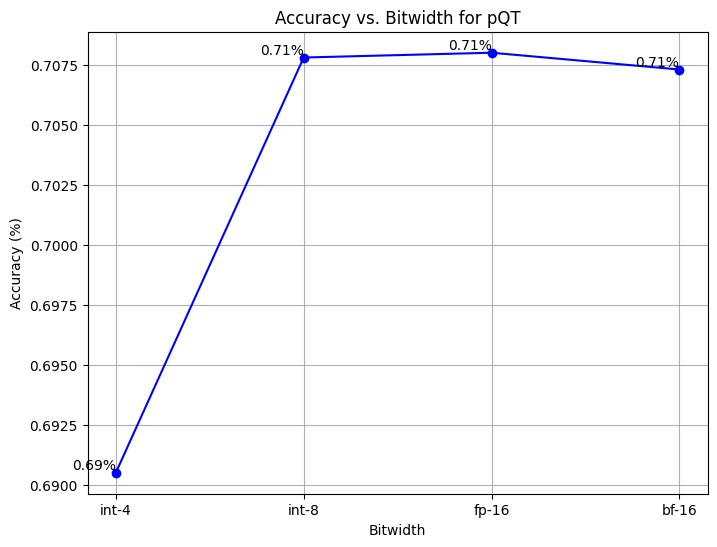

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_bitwidth(bitwidths, accuracies):    
    plt.figure(figsize=(8, 6))
    plt.plot(bitwidths, accuracies, marker='o', linestyle='-', color='b', markersize=6)
    plt.title("Accuracy vs. Bitwidth for pQT")
    plt.xlabel("Bitwidth")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    
    for bw, acc in zip(bitwidths, accuracies):
        plt.text(bw, acc, f'{acc:.2f}%', ha='right', va='bottom')

    plt.show()

bitwidths = ["int-4", "int-8", "fp-16", "bf-16"]
accuracies = [0.6905, 0.7078, 0.708, 0.7073]
plot_accuracy_vs_bitwidth(bitwidths, accuracies)


# QAT Accuracy vs Bit-width

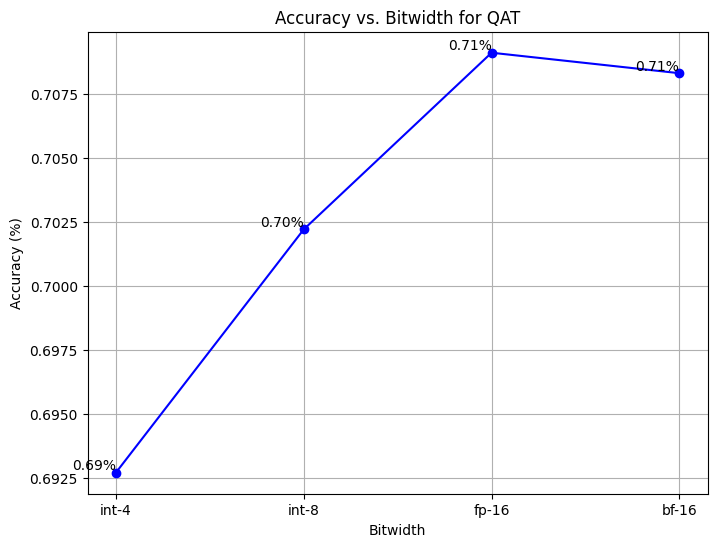

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_bitwidth(bitwidths, accuracies):    
    plt.figure(figsize=(8, 6))
    plt.plot(bitwidths, accuracies, marker='o', linestyle='-', color='b', markersize=6)
    plt.title("Accuracy vs. Bitwidth for QAT")
    plt.xlabel("Bitwidth")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    
    for bw, acc in zip(bitwidths, accuracies):
        plt.text(bw, acc, f'{acc:.2f}%', ha='right', va='bottom')

    plt.show()

bitwidths = ["int-4", "int-8", "fp-16", "bf-16"]
accuracies = [0.6927, 0.7022, 0.7091, 0.7083]
plot_accuracy_vs_bitwidth(bitwidths, accuracies)


# No. of Epochs for QAT to match PQT across different bit-widths.

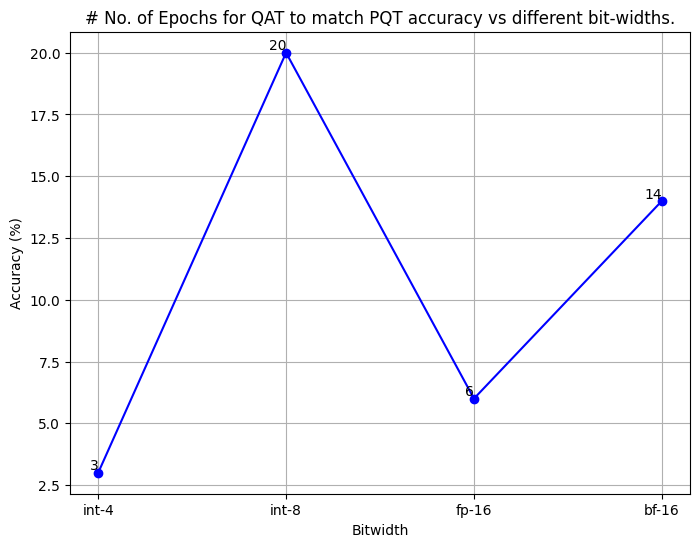

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_bitwidth(bitwidths, accuracies):    
    plt.figure(figsize=(8, 6))
    plt.plot(bitwidths, accuracies, marker='o', linestyle='-', color='b', markersize=6)
    plt.title("# No. of Epochs for QAT to match PQT accuracy vs different bit-widths.")
    plt.xlabel("Bitwidth")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    
    for bw, acc in zip(bitwidths, accuracies):
        plt.text(bw, acc, acc, ha='right', va='bottom')

    plt.show()

bitwidths = ["int-4", "int-8", "fp-16", "bf-16"]
accuracies = [3, 20, 6, 14]
plot_accuracy_vs_bitwidth(bitwidths, accuracies)


## FP-16 vs BF-16

### PQT memory stats for fp-16 and bf-16.

In [17]:
print("Memory of fp-16 quantized PQT  model: ", 156741904 / (8 * 1024 ** 2))
print("Memory of bf-16 quantized PQT  model: ", 156841536 / (8 * 1024 ** 2))
print("Accuracy of fp-16 quantized PQT  model: ", 0.708)
print("Accuracy of bf-16 quantized PQT  model: ", 0.7073)
print("bf-16 PQT quantized model has a slightly larger memory footprint.")
print("fp-16 PQT quantized model has a slightly better accuracy.")

Memory of fp-16 quantized PQT  model:  18.685091018676758
Memory of bf-16 quantized PQT  model:  18.69696807861328
Accuracy of fp-16 quantized PQT  model:  0.708
Accuracy of bf-16 quantized PQT  model:  0.7073
bf-16 PQT quantized model has a slightly larger memory footprint.
fp-16 PQT quantized model has a slightly better accuracy.


### QAT memory stats for fp-16 and bf-16 after 8 epochs.

In [20]:
print("Memory of fp-16 quantized QAT  model: ", 156841536 / (8 * 1024 ** 2))
print("Memory of bf-16 quantized QAT  model: ", 156841536 / (8 * 1024 ** 2))
print("fp-16 quantized PQT model: Test Accuracy: 0.705")
print("bf-16 quantized PQT model: Test Accuracy: 0.7029")
print("bf-16 QAT and fp-16 QAT have the exact same memory footprint.")
print("fp-16 PQT quantized model has a slightly better accuracy.")
print("It took bf-16 8 times longer to run QAT for 8 epochs than fp-16. (3 mins vs 24 mins)")

Memory of fp-16 quantized QAT  model:  18.69696807861328
Memory of bf-16 quantized QAT  model:  18.69696807861328
fp-16 quantized PQT model: Test Accuracy: 0.705
bf-16 quantized PQT model: Test Accuracy: 0.7029
bf-16 QAT and fp-16 QAT have the exact same memory footprint.
fp-16 PQT quantized model has a slightly better accuracy.
It took bf-16 8 times longer to run QAT for 8 epochs than fp-16. (3 mins vs 24 mins)
